In [1]:
import pandas as pd
import numpy as np

weather_path = "../data/au_adelaide_act.csv"
solar_path = "../data/au_sa_iso_satellite_pv_load_act.csv"
total_path = '../data/au_sa_total_load_complete.csv'
load_path = '../data/au_sa_load_act.csv'

# load and store datasets
weather = pd.read_csv(weather_path, na_values='-99')
solar = pd.read_csv(solar_path, na_values='-99')
total = pd.read_csv(total_path, na_values='-99', parse_dates=['datetime'])
load = pd.read_csv(load_path, na_values='-99')

Combine date and time to datetime for datasets where this is necessary - all but `total`.

In [2]:
def to_datetime_df(df):
    date = df['date'].astype('str')
    time = df['time'].astype('str').str.pad(4, fillchar='0')
    df['datetime'] = pd.to_datetime(date + time, format = '%Y%m%d%H%M')
    df_d = df.drop(['date', 'time'], axis = 1)
    return df_d

weather_d = to_datetime_df(weather)
solar_d = to_datetime_df(solar)
load = to_datetime_df(load)

Weather data is hourly, so upsample to 30 minute increments and use linear interpolation to fill values.

In [3]:
weather_resample = weather_d.set_index('datetime').resample('30min').asfreq()
weather_interpolate = weather_resample.interpolate()
weather_interpolate.head()

,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2
datetime,,,,,,,
2016-01-01 00:00:00,27.40,3.0,5.0,80.0,19.0,0.0,NaN
2016-01-01 00:30:00,26.10,5.0,5.0,205.0,27.0,0.0,NaN
2016-01-01 01:00:00,24.80,7.0,5.0,330.0,35.0,0.0,NaN
2016-01-01 01:30:00,24.25,5.5,4.5,315.0,49.0,0.0,NaN
2016-01-01 02:00:00,23.70,4.0,4.0,300.0,63.0,0.0,NaN


Now, join weather and solar on matching timestamps.

In [4]:
weather_solar = pd.merge(weather_interpolate, solar_d, on='datetime', how='inner', copy=False, validate='1:1')
weather_solar.rename({'load_act': 'pv_est'}, axis=1, inplace=True)
weather_solar.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989


Now join again with net load.

In [5]:
ws_load = pd.merge(weather_solar, load, on='datetime', how='inner', copy=False, validate='1:1')
ws_load.rename({'load_act': 'net_load'}, axis=1, inplace=True)
ws_load.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122


And join again with total load.

In [6]:
merged = pd.merge(ws_load, total, on='datetime', how='inner', copy=False, validate='1:1')
merged.rename({'load_act': 'total_load'}, axis=1, inplace=True)
merged.head()

,datetime,tempc,cloud8,windk,wdir,humid,rainmm,radkjm2,pv_est,net_load,total_load
0,2018-03-06 09:30:00,20.75,2.5,14.5,135.0,44.5,0.0,1915.0,318.991,1288,1136.79
1,2018-03-06 10:00:00,21.50,1.0,16.0,140.0,40.0,0.0,2340.0,375.231,1237,1054.87
2,2018-03-06 10:30:00,22.25,1.5,15.5,145.0,37.0,0.0,2570.0,430.909,1189,1002.35
3,2018-03-06 11:00:00,23.00,2.0,15.0,150.0,34.0,0.0,2800.0,485.129,1150,971.54
4,2018-03-06 11:30:00,23.55,2.0,13.0,145.0,32.0,0.0,2945.0,523.989,1122,943.68


Ensure result is sorted by timestamp.

In [7]:
merged.sort_values(by='datetime', inplace=True)

Plot all columns against timestamp as a sanity check.

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>], dtype=object)

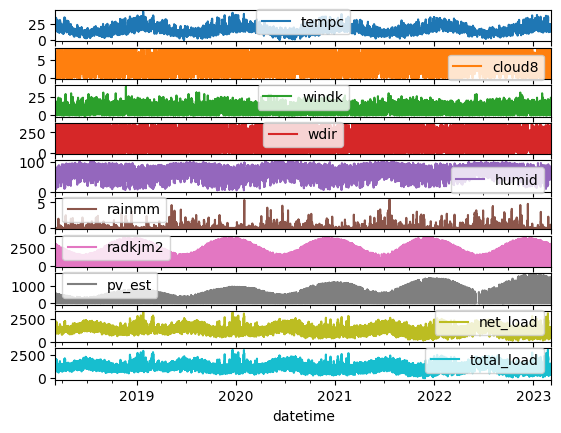

In [8]:
merged.plot(x='datetime', subplots=True)

Write to file.

In [9]:
merged.to_csv('../data/sa/merged_interpolated.csv', index=False)